# Insatling of dtreeviz

In [1]:
import sys
import os

In [2]:
%config InlineBackend.figure_format = 'retina' # Make visualizations look good
#%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

if 'google.colab' in sys.modules:
  !pip install -q dtreeviz
  !pip install -q lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.5/90.5 KB 3.6 MB/s eta 0:00:00


In [91]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import matplotlib.pyplot as plt

import dtreeviz

random_state = 1234 # get reproducible trees

# classifier

In [33]:
dataset = pd.read_csv('/train.csv')

In [34]:
dataset.fillna({"Age":dataset.Age.mean()}, inplace=True)
# Encode categorical variables
dataset["Sex_label"] = dataset.Sex.astype("category").cat.codes
dataset["Cabin_label"] = dataset.Cabin.astype("category").cat.codes
dataset["Embarked_label"] = dataset.Embarked.astype("category").cat.codes

In [39]:
features = ["Pclass", "Sex_label", "Embarked_label", "Age", "Cabin_label", "Fare"]
target = "Survived"

X_train, X_test, y_train, y_test = train_test_split(dataset[features], dataset[target], test_size=0.2, random_state=42)

train_data = lgb.Dataset(data=X_train, label=y_train, feature_name=features, categorical_feature=["Sex_label", "Pclass"])
valid_data = lgb.Dataset(data=X_test, label=y_test, feature_name=features, categorical_feature=["Sex_label", "Pclass"])

lgbm_params = {
    'boosting': 'dart',          # dart (drop out trees) often performs better
    'application': 'binary',     # Binary classification
    'learning_rate': 0.05,       # Learning rate, controls size of a gradient descent step
    'min_data_in_leaf': 2,      # Data set is quite small so reduce this a bit
    'feature_pre_filter': False,
    'feature_fraction': 0.7,     # Proportion of features in each boost, controls overfitting
    'num_leaves': 41,            # Controls size of tree since LGBM uses leaf wise splits
    'drop_rate': 0.15,
    'max_depth':4,
    "seed":1212}

lgbm_model = lgb.train(lgbm_params, train_data, valid_sets=[train_data, valid_data], verbose_eval=False)

In [40]:
viz_model = dtreeviz.model(lgbm_model, tree_index=1,
                           X_train=dataset[features], y_train=dataset[target],
                           feature_names=features,
                           target_name=target, class_names=["perish", "survive"])

AttributeError: ignored

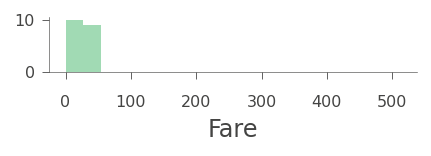

In [41]:
viz_model.view()

# Pipelining

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

In [12]:
features = ["Pclass", "Age", "Fare", "Sex_label", "Cabin_label", "Embarked_label"]
target = "Survived"

In [13]:
model = make_pipeline(
    VarianceThreshold(0.5),
    PolynomialFeatures(degree=2, interaction_only=True),
    DecisionTreeClassifier(max_depth=4))

In [14]:
model.fit(dataset[features], dataset[target])

Pipeline(steps=[('variancethreshold', VarianceThreshold(threshold=0.5)),
                ('polynomialfeatures',
                 PolynomialFeatures(interaction_only=True)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=4))])

In [15]:
from dtreeviz.utils import extract_params_from_pipeline

In [16]:
tree_classifier, X_train, features_model = extract_params_from_pipeline(
    pipeline=model,
    X_train=dataset[features],
    feature_names=features)

In [17]:
y_train = dataset[target]
features_model

['1',
 'Pclass',
 'Age',
 'Fare',
 'Cabin_label',
 'Embarked_label',
 'Pclass Age',
 'Pclass Fare',
 'Pclass Cabin_label',
 'Pclass Embarked_label',
 'Age Fare',
 'Age Cabin_label',
 'Age Embarked_label',
 'Fare Cabin_label',
 'Fare Embarked_label',
 'Cabin_label Embarked_label']

In [18]:
viz_model = dtreeviz.model(tree_classifier,
                           X_train=X_train, y_train=y_train,
                           feature_names=features_model,
                           target_name=target, class_names=["perish", "survive"])

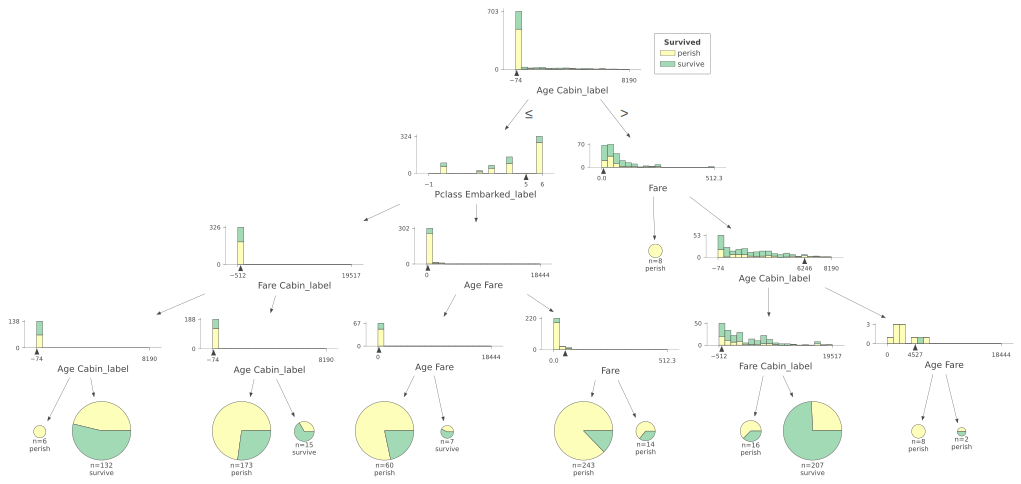

In [20]:
viz_model.view()

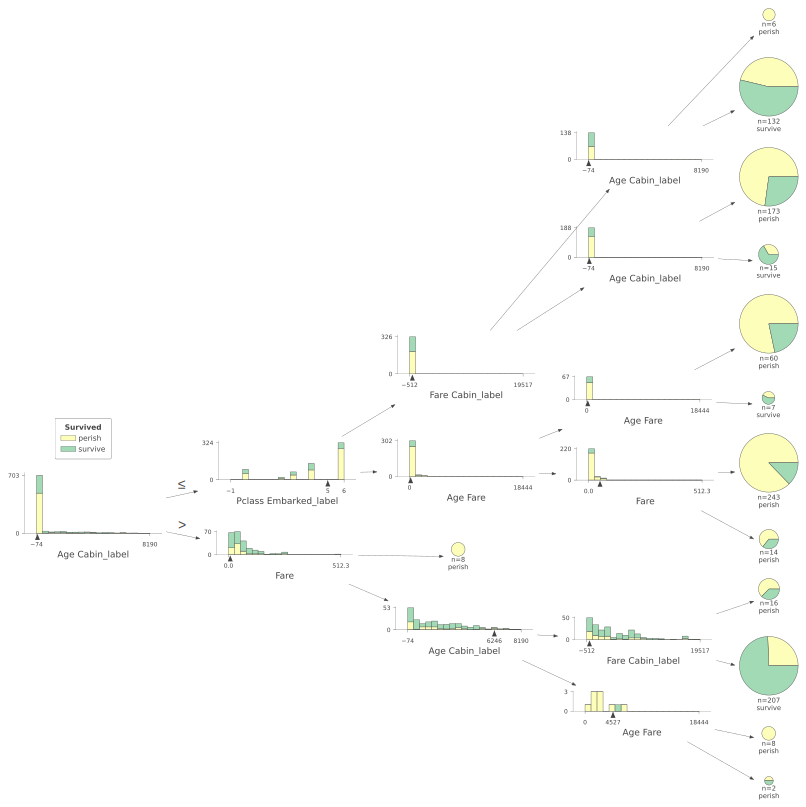

In [21]:
viz_model.view(orientation="LR")

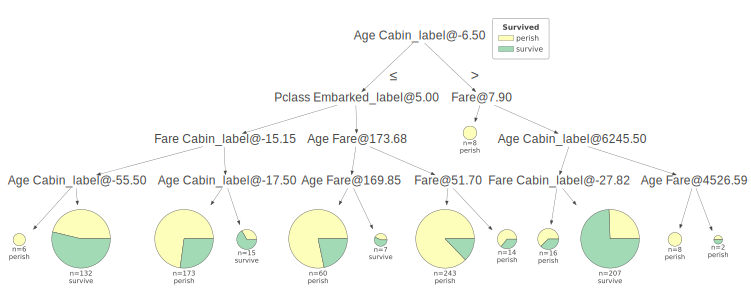

In [22]:
viz_model.view(fancy=False)

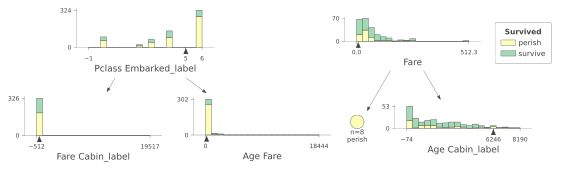

In [23]:
viz_model.view(depth_range_to_display=(1, 2)) # root is level 0

In [24]:
x = X_train.iloc[10]
x

1                                1.0
Pclass                           3.0
Age                              4.0
Fare                            16.7
Cabin_label                    145.0
Embarked_label                   2.0
Pclass Age                      12.0
Pclass Fare                     50.1
Pclass Cabin_label             435.0
Pclass Embarked_label            6.0
Age Fare                        66.8
Age Cabin_label                580.0
Age Embarked_label               8.0
Fare Cabin_label              2421.5
Fare Embarked_label             33.4
Cabin_label Embarked_label     290.0
Name: 10, dtype: float64

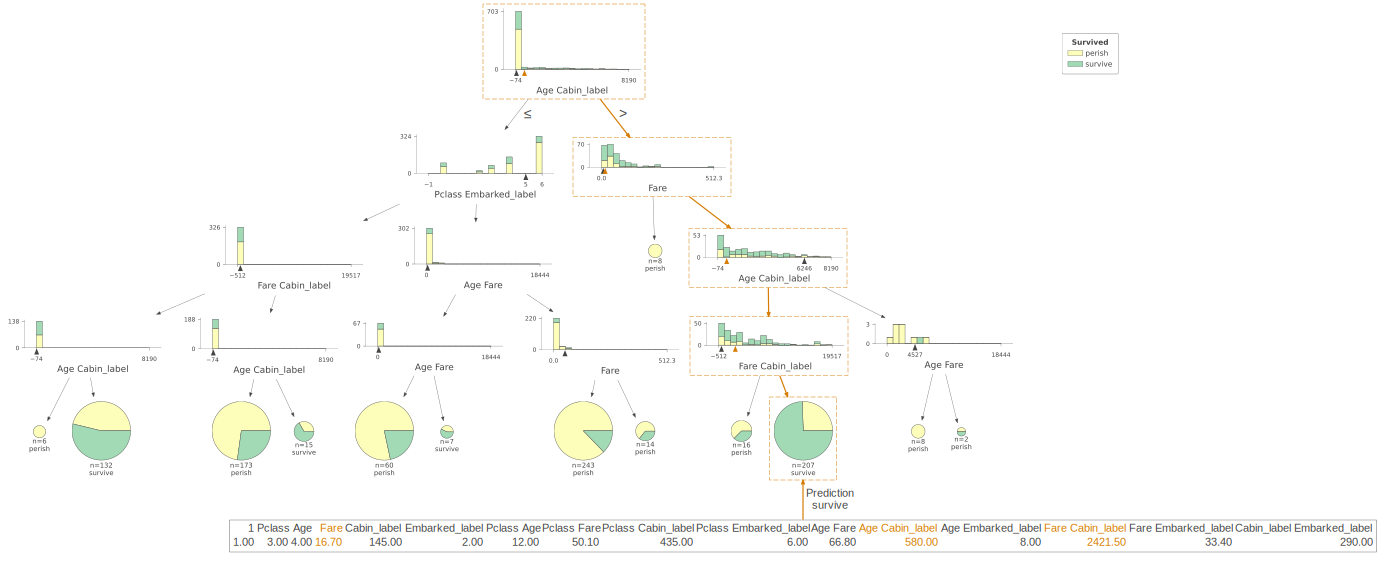

In [25]:
viz_model.view(x=x)

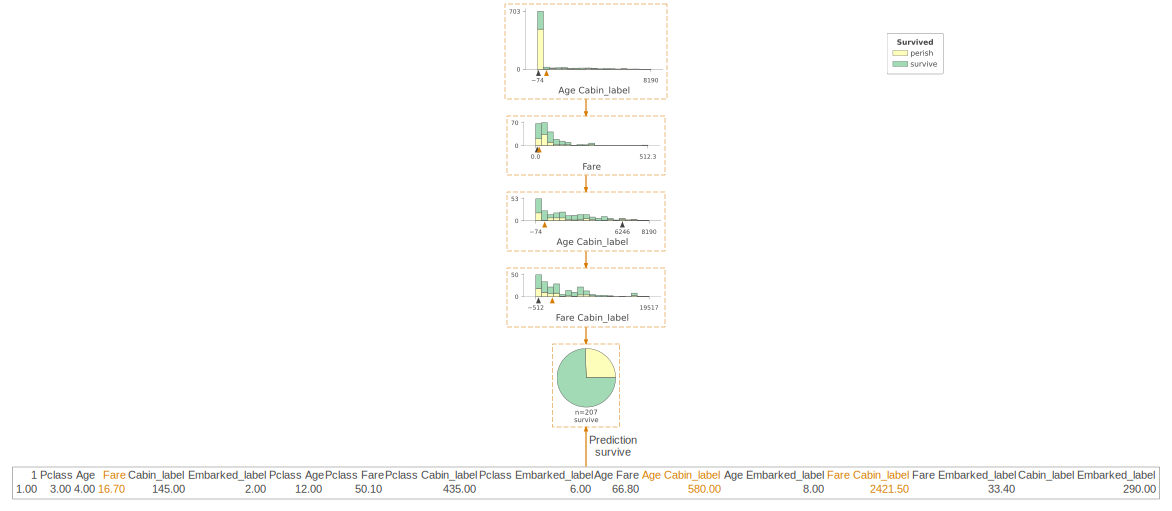

In [26]:
viz_model.view(x=x, show_just_path=True)

In [27]:
print(viz_model.explain_prediction_path(x))

7.9 <= Fare 
-6.5 <= Age Cabin_label  < 6245.5
-27.82 <= Fare Cabin_label 



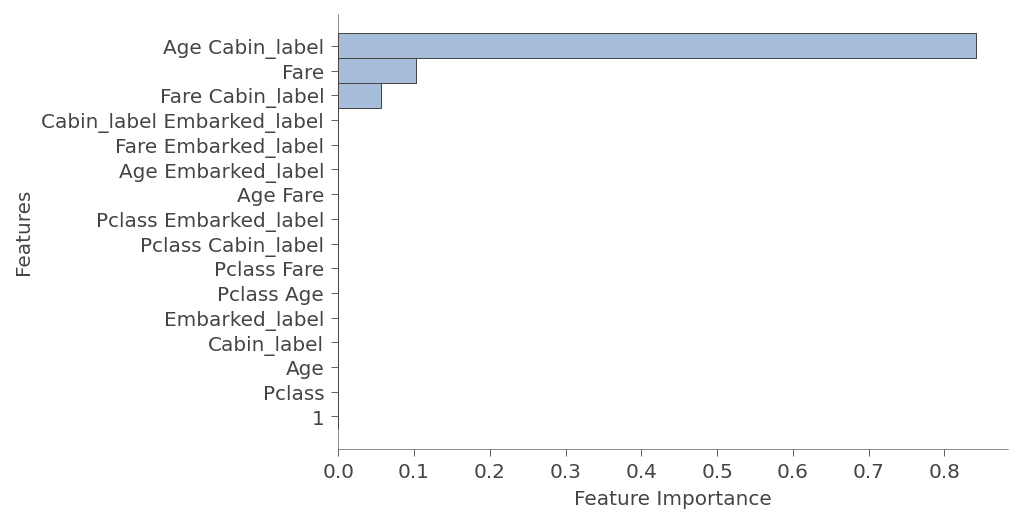

In [28]:
viz_model.instance_feature_importance(x)

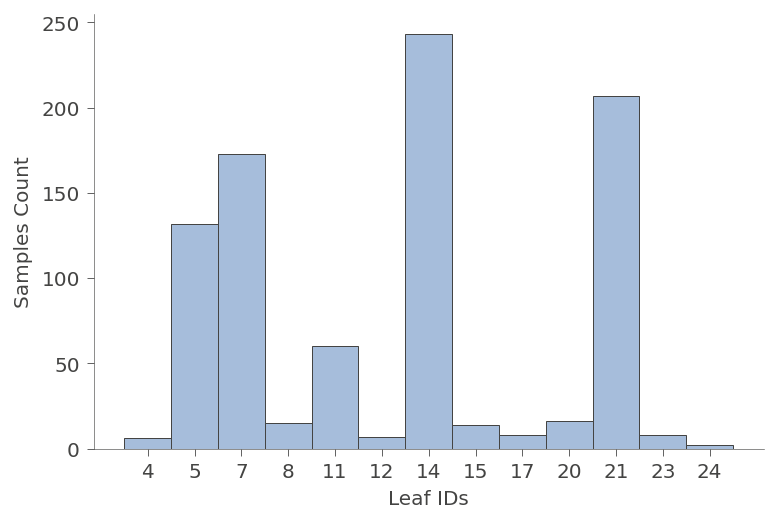

In [29]:
viz_model.leaf_sizes()

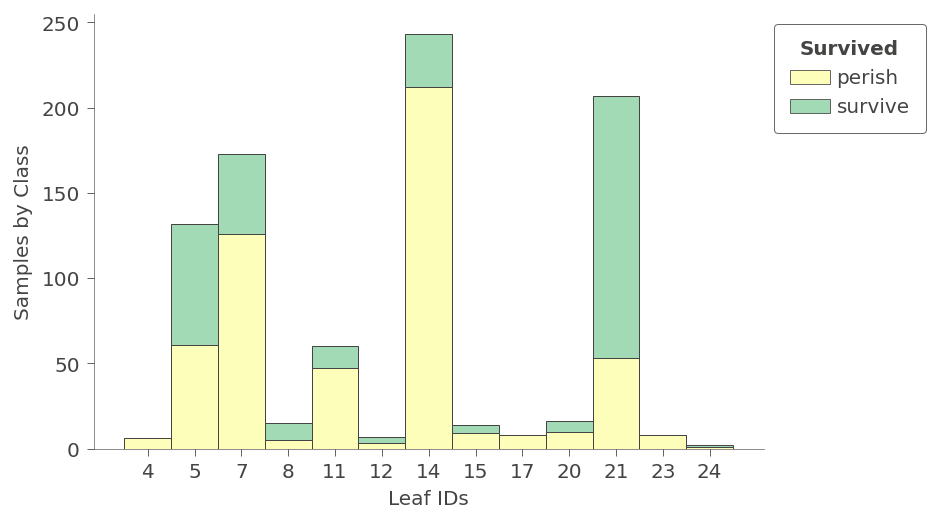

In [30]:
viz_model.ctree_leaf_distributions()

In [31]:
viz_model.node_stats(node_id=14)

1  Pclass         Age        Fare  Cabin_label  Embarked_label  \
count  243.0   243.0  243.000000  243.000000        243.0           243.0   
mean     1.0     3.0   30.080466   13.064468         -1.0             2.0   
std      0.0     0.0    9.713770    9.057148          0.0             0.0   
min      1.0     3.0    7.000000    6.237500         -1.0             2.0   
25%      1.0     3.0   25.000000    7.895800         -1.0             2.0   
50%      1.0     3.0   29.699118    8.050000         -1.0             2.0   
75%      1.0     3.0   33.500000   15.975000         -1.0             2.0   
max      1.0     3.0   74.000000   46.900000         -1.0             2.0   

       Pclass Age  Pclass Fare  Pclass Cabin_label  Pclass Embarked_label  \
count  243.000000   243.000000               243.0                  243.0   
mean    90.241398    39.193405                -3.0                    6.0   
std     29.141311    27.171443                 0.0                    0.0   
min     21.000000    18.712500                -3.0                    6.0   
25%     75.000000    23.687400                -3.0                    6.0   
50%     89.097353    24.150000                -3.0                    6.0   
75%    100.500000    47.925000                -3.0                    6.0   
max    222.000000   140.700000                -3.0                    6.0   

          Age Fare  Age Cabin_label  Age Embarked_label  Fare Cabin_label  \
count   243.000000       243.000000          243.000000        243.000000   
mean    365.770829       -30.080466           60.160932        -13.064468   
std     256.760779         9.713770           19.427541          9.057148   
min     173.707600       -74.000000           14.000000        -46.900000   
25%     223.064169       -33.500000           50.000000        -15.975000   
50%     266.000000       -29.699118           59.398235         -8.050000   
75%     414.575000       -25.000000           67.000000         -7.895800   
max    2016.700000        -7.000000          148.000000         -6.237500   

       Fare Embarked_label  Cabin_label Embarked_label  
count           243.000000                       243.0  
mean             26.128937                        -2.0  
std              18.114295                         0.0  
min              12.475000                        -2.0  
25%              15.791600                        -2.0  
50%              16.100000                        -2.0  
75%              31.950000                        -2.0  
max              93.800000                        -2.0

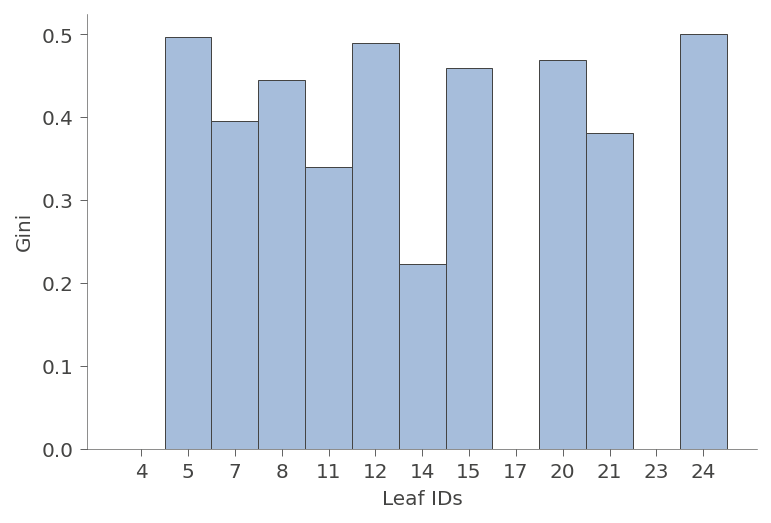

In [32]:
viz_model.leaf_purity()

# visulaziation

## A)Classfication

In [44]:
features = ["Pclass", "Age", "Fare", "Sex_label", "Cabin_label", "Embarked_label"]
target = "Survived"

tree_classifier = DecisionTreeClassifier(max_depth=3, random_state=random_state)
tree_classifier.fit(dataset[features].values, dataset[target].values)

DecisionTreeClassifier(max_depth=3, random_state=1234)

In [45]:
viz_model = dtreeviz.model(tree_classifier,
                           X_train=dataset[features], y_train=dataset[target],
                           feature_names=features,
                           target_name=target, class_names=["perish", "survive"])

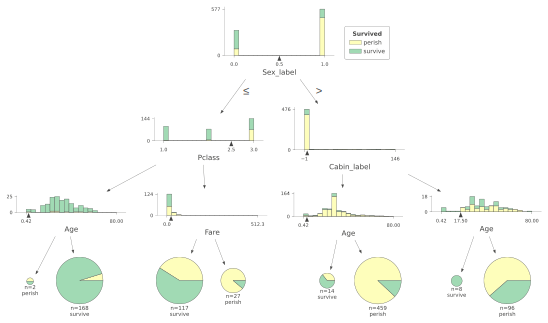

In [46]:
viz_model.view(scale=0.8)

In [47]:
viz_model = dtreeviz.model(tree_classifier,
                           X_train=dataset[features], y_train=dataset[target],
                           feature_names=features,
                           target_name=target, class_names=["perish", "survive"])

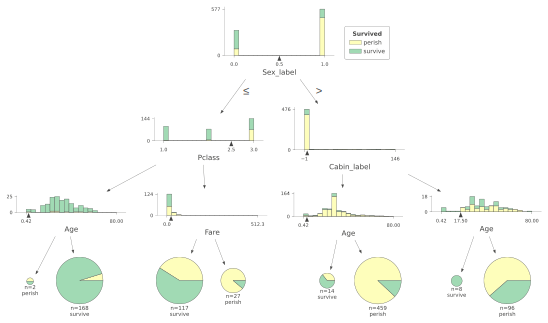

In [48]:
viz_model.view(scale=0.8)

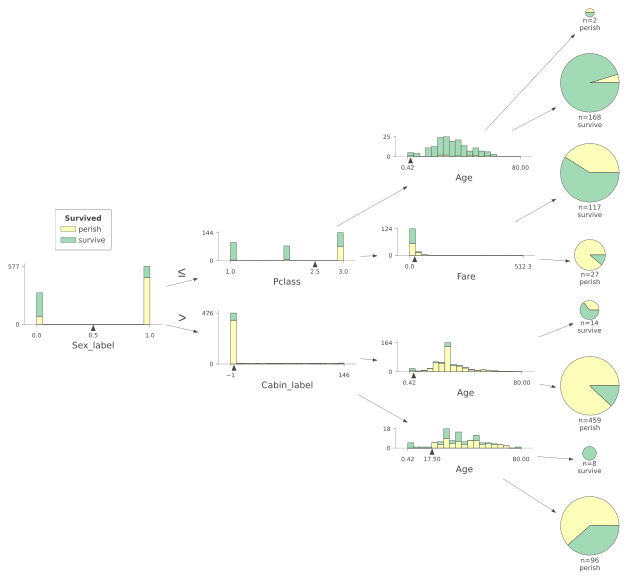

In [49]:
viz_model.view(orientation="LR")

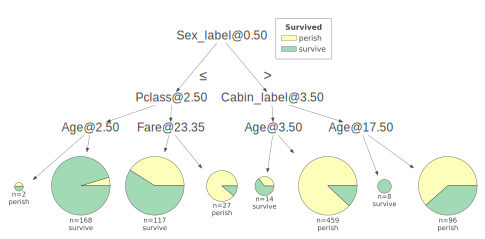

In [51]:
viz_model.view(fancy=False)

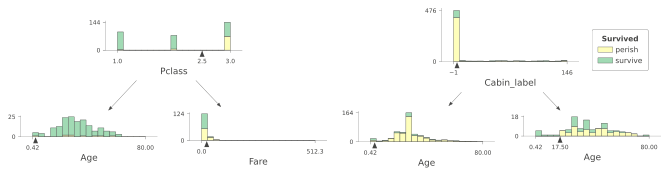

In [52]:
viz_model.view(depth_range_to_display=(1, 2))

In [53]:
x = dataset[features].iloc[10]
x

Pclass              3.0
Age                 4.0
Fare               16.7
Sex_label           0.0
Cabin_label       145.0
Embarked_label      2.0
Name: 10, dtype: float64

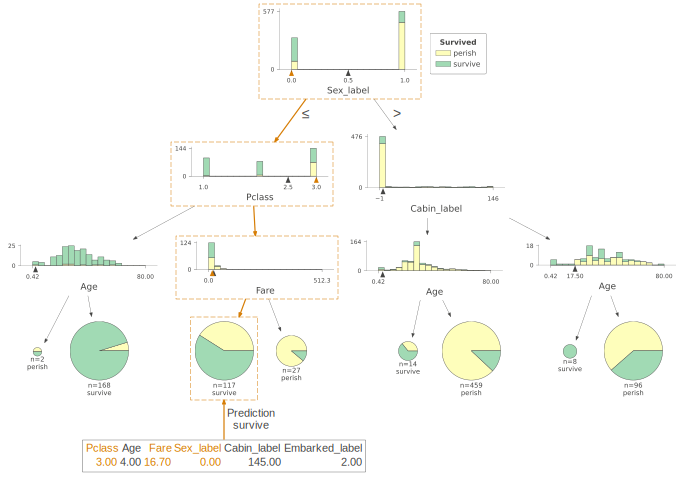

In [54]:
viz_model.view(x=x)

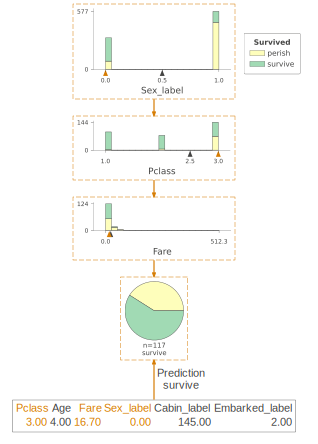

In [55]:
viz_model.view(x=x, show_just_path=True)

In [56]:
print(viz_model.explain_prediction_path(x))

2.5 <= Pclass 
Fare < 23.35
Sex_label < 0.5



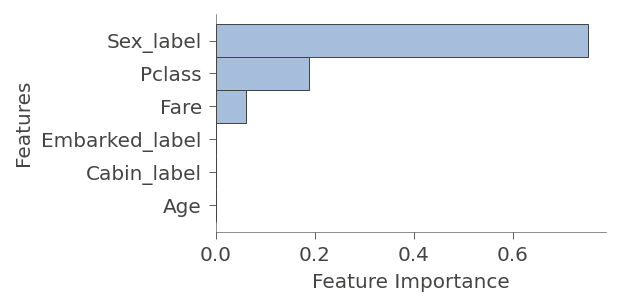

In [57]:
viz_model.instance_feature_importance(x, figsize=(3.5,2))

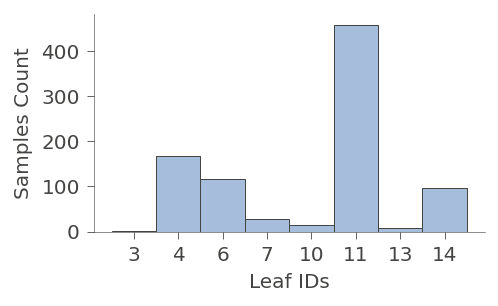

In [58]:
viz_model.leaf_sizes(figsize=(3.5,2))

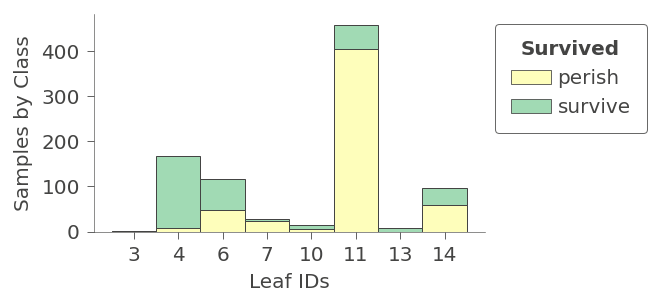

In [59]:
viz_model.ctree_leaf_distributions(figsize=(3.5,2))

In [60]:
viz_model.node_stats(node_id=6)

Pclass         Age        Fare  Sex_label  Cabin_label  Embarked_label
count   117.0  117.000000  117.000000      117.0   117.000000      117.000000
mean      3.0   23.976667   11.722829        0.0     6.196581        1.341880
std       0.0   10.534377    4.695136        0.0    31.167855        0.789614
min       3.0    0.750000    6.750000        0.0    -1.000000        0.000000
25%       3.0   18.000000    7.775000        0.0    -1.000000        1.000000
50%       3.0   27.000000    9.587500        0.0    -1.000000        2.000000
75%       3.0   29.699118   15.500000        0.0    -1.000000        2.000000
max       3.0   63.000000   23.250000        0.0   145.000000        2.000000

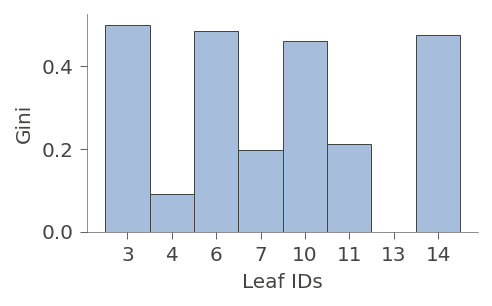

In [61]:
viz_model.leaf_purity(figsize=(3.5,2))

In [64]:
features_reg = ["Pclass", "Fare", "Sex_label", "Cabin_label", "Embarked_label", "Survived"]
target_reg = "Age"

tree_regressor = DecisionTreeRegressor(max_depth=3, random_state=random_state, criterion="absolute_error")
tree_regressor.fit(dataset[features_reg].values, dataset[target_reg].values)

DecisionTreeRegressor(criterion='absolute_error', max_depth=3,
                      random_state=1234)

In [65]:
viz_rmodel = dtreeviz.model(model=tree_regressor, 
                            X_train=dataset[features_reg], 
                            y_train=dataset[target_reg], 
                            feature_names=features_reg, 
                            target_name=target_reg)

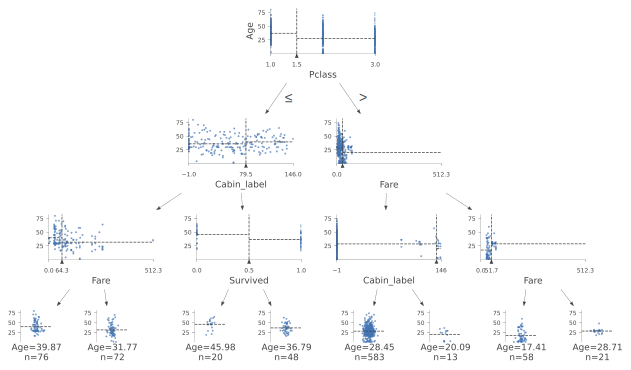

In [66]:
viz_rmodel.view()

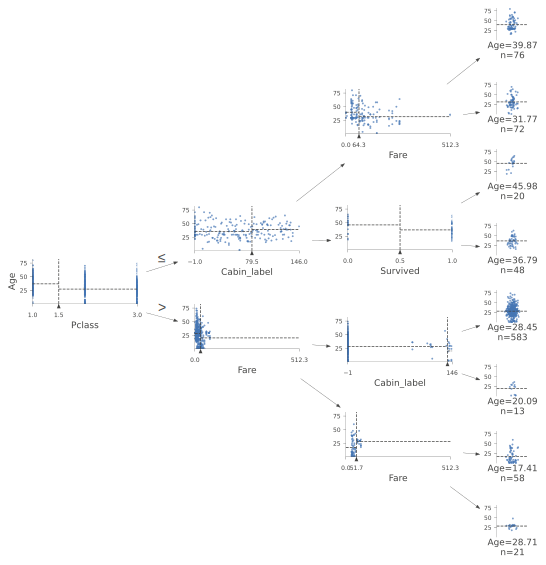

In [67]:
viz_rmodel.view(orientation="LR")

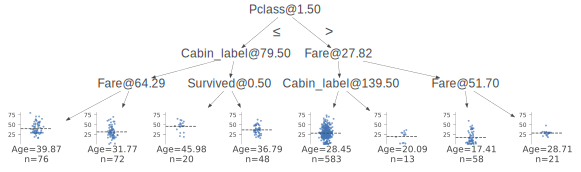

In [68]:
viz_rmodel.view(fancy=False)

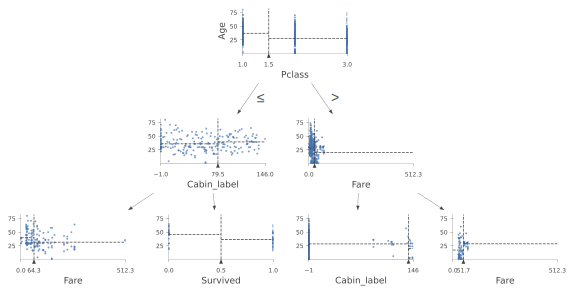

In [69]:
viz_rmodel.view(depth_range_to_display=(0, 2))

In [70]:
x = dataset[features_reg].iloc[10]
x

Pclass              3.0
Fare               16.7
Sex_label           0.0
Cabin_label       145.0
Embarked_label      2.0
Survived            1.0
Name: 10, dtype: float64

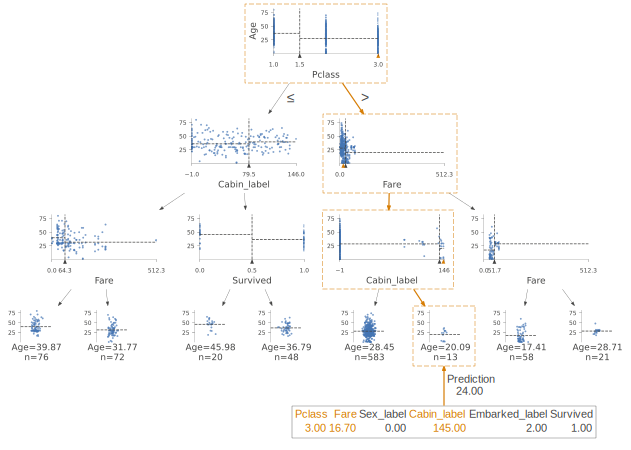

In [71]:
viz_rmodel.view(x = x)

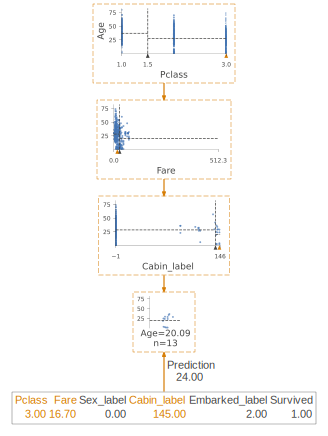

In [72]:
viz_rmodel.view(show_just_path=True, x = x)

In [73]:
print(viz_rmodel.explain_prediction_path(x))

1.5 <= Pclass 
Fare < 27.82
139.5 <= Cabin_label 



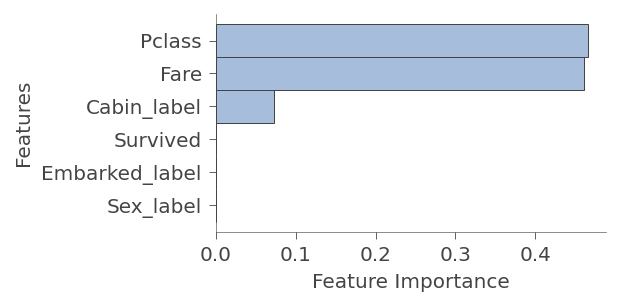

In [74]:
viz_rmodel.instance_feature_importance(x, figsize=(3.5,2))

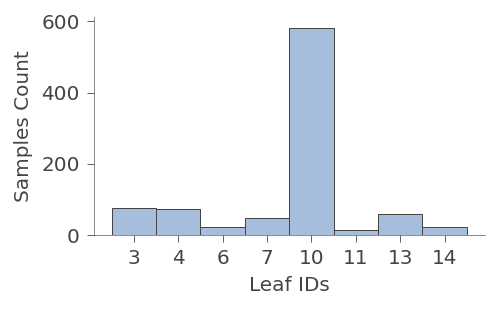

In [75]:
viz_rmodel.leaf_sizes(figsize=(3.5,2))

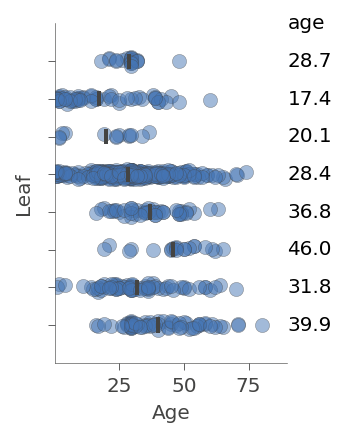

In [76]:
viz_rmodel.rtree_leaf_distributions()

In [77]:
viz_rmodel.node_stats(node_id=4)

Pclass        Fare  Sex_label  Cabin_label  Embarked_label   Survived
count    72.0   72.000000  72.000000    72.000000       72.000000  72.000000
mean      1.0  152.167936   0.347222    39.250000        0.916667   0.763889
std       0.0   97.808005   0.479428    26.556742        1.031203   0.427672
min       1.0   66.600000   0.000000    -1.000000       -1.000000   0.000000
25%       1.0   83.158300   0.000000    20.750000        0.000000   1.000000
50%       1.0  120.000000   0.000000    40.000000        0.000000   1.000000
75%       1.0  211.337500   1.000000    63.000000        2.000000   1.000000
max       1.0  512.329200   1.000000    79.000000        2.000000   1.000000

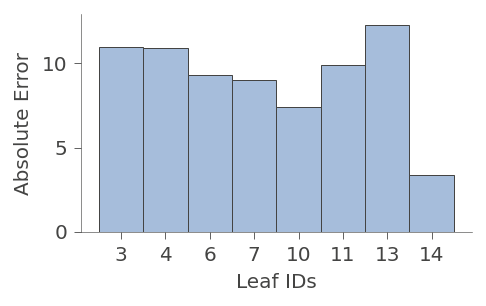

In [78]:
viz_rmodel.leaf_purity(figsize=(3.5,2))

## regression

In [79]:
from sklearn.datasets import load_iris
iris = load_iris()
features = list(iris.feature_names)
class_names = iris.target_names
X = iris.data
y = iris.target

In [80]:
dtc_iris = DecisionTreeClassifier(max_depth=2, min_samples_leaf=1, random_state=666)
dtc_iris.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=666)

In [81]:
viz_model = dtreeviz.model(dtc_iris,
                           X_train=X, y_train=y,
                           feature_names=features,
                           target_name='iris',
                           class_names=class_names)

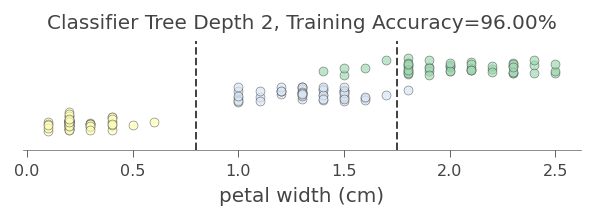

In [82]:
viz_model.ctree_feature_space(show={'splits','title'}, features=['petal width (cm)'],
                             figsize=(5,1))

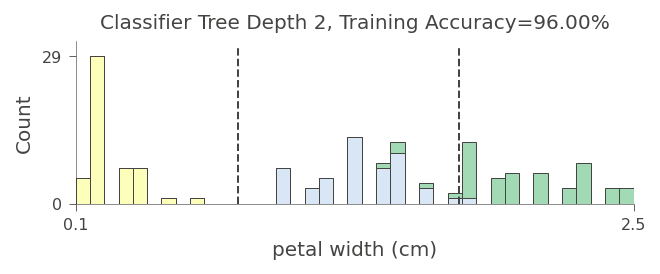

In [83]:
viz_model.ctree_feature_space(nbins=40, gtype='barstacked', show={'splits','title'}, features=['petal width (cm)'],
                             figsize=(5,1.5))

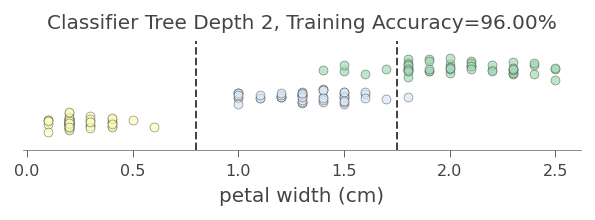

In [84]:
viz_model.ctree_feature_space(show={'splits','title'}, features=['petal width (cm)'],
                              figsize=(5,1))

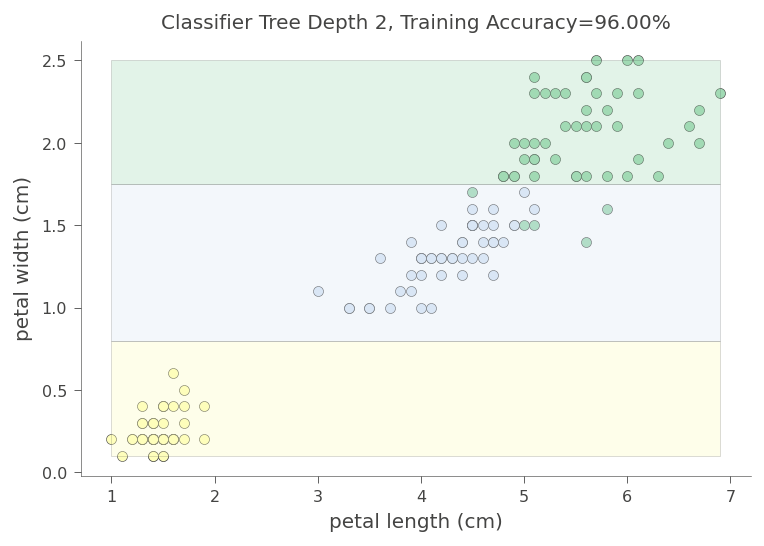

In [85]:
viz_model.ctree_feature_space(show={'splits','title'}, features=['petal length (cm)', 'petal width (cm)'])

In [95]:
df_cars = pd.read_csv('/cars.csv')

In [96]:
X = df_cars.drop('MPG', axis=1)
y = df_cars['MPG']
features = list(X.columns)

In [97]:
df_cars = DecisionTreeRegressor(max_depth=3, criterion="absolute_error")
df_cars.fit(X.values, y.values)

DecisionTreeRegressor(criterion='absolute_error', max_depth=3)

In [98]:
viz_rmodel = dtreeviz.model(df_cars, X, y,
                            feature_names=features,
                            target_name='MPG')

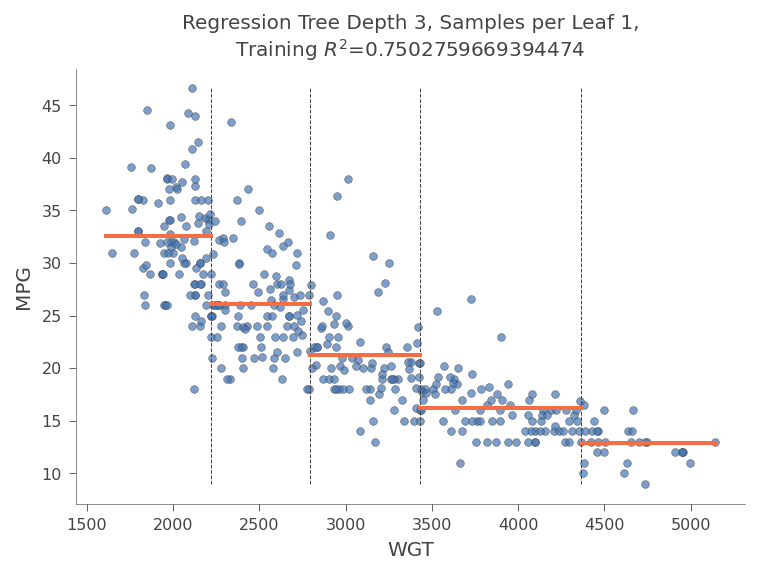

In [99]:
viz_rmodel.rtree_feature_space(features=['WGT'])

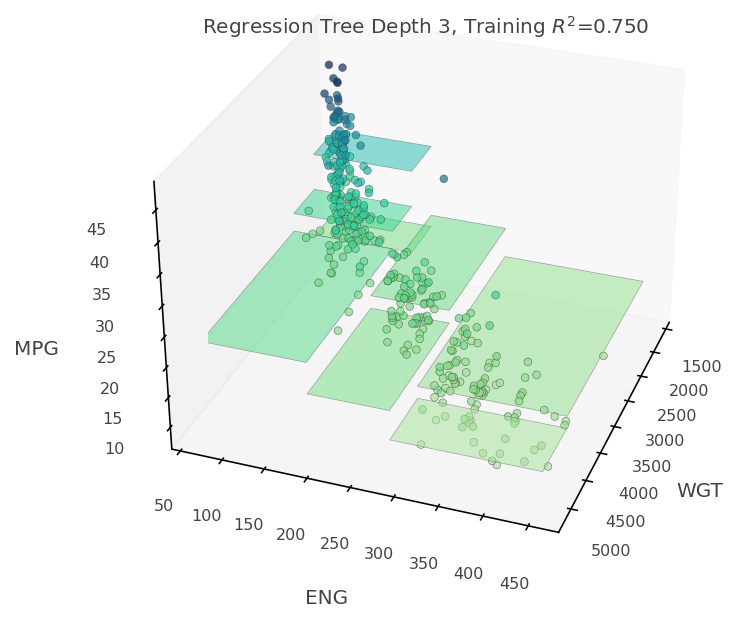

In [100]:
viz_rmodel.rtree_feature_space3D(features=['WGT','ENG'],
                                 fontsize=10,
                                 elev=30, azim=20,
                                 show={'splits', 'title'},
                                 colors={'tessellation_alpha': .5})

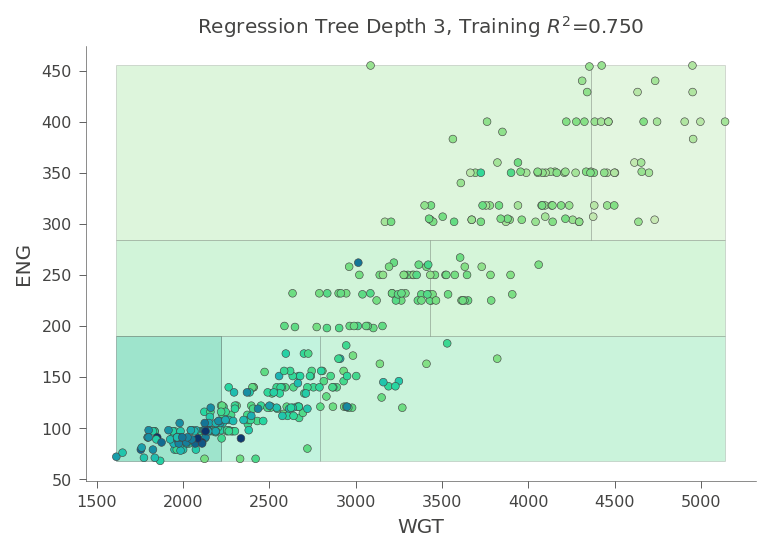

In [101]:
viz_rmodel.rtree_feature_space(features=['WGT','ENG'])